<a href="https://www.kaggle.com/code/zygimantasmarma/blood-estimation?scriptVersionId=113932209" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

Steps on how to solve this problem:
1. Perform literature analysis on recommended papers [1-4] // TODO: add links at the end
1. Process (filter) ECG and FPG signals
1. Evaluate signal parameters PAT, PIR and HR [2]
1. Create a regression model evaluating systolic and diastolic blood pressure parameters
1. To quantify the effectiveness of the regression model
1. Create a classification model that classifies changes in systolic blood pressure into three categories: 
    *     Increase >10mmHg 
    *     Decrease < -10mmHg
    *     Insignificant changes (-10; 10) mmHg.
1. Evaluate the performen of the classification model (Acc, Spec, F1 ...)

Import needed libs:

In [310]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy import signal

plt.rcParams['figure.figsize'] = [16, 8] # Matplotlib config

# This will show datasets paths TODO: delete after
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/painlesparams/y_val_s_01.dat
/kaggle/input/painlesparams/y_val_s_02.dat
/kaggle/input/painlesparams/x_val_s_02.dat
/kaggle/input/painlesparams/x_s_01.dat
/kaggle/input/painlesparams/x_val_s_01.dat
/kaggle/input/painlesparams/y_s_02.dat
/kaggle/input/painlesparams/x_s_02.dat
/kaggle/input/painlesparams/y_s_01.dat
/kaggle/input/painlesparams/matlabSignals.mat
/kaggle/input/d/zygimantasmarma/painlessdb/Painless011.mat
/kaggle/input/d/zygimantasmarma/painlessdb/Painless021.mat


Load .mat data and covert to proper python arrays:

In [311]:
matData = scipy.io.loadmat('/kaggle/input/d/zygimantasmarma/painlessdb/Painless021.mat') # Specific data path for kaggle

print(type(matData))
print(matData)

bp = matData.get('bp')[0] # not sure why you get arrays of arrays
ecg = matData.get('ecg')[0] # note: this is 3x array
ecg_2 = matData.get('ecg')[1] # note: this is 3x array
ecg_3 = matData.get('ecg')[1] # note: this is 3x array

ppg = matData.get('ppg')[0]

f_bp = matData.get('f_bp')[0]
f_ecg = matData.get('f_ecg')[0]
f_ppg = matData.get('f_ppg')[0]

<class 'dict'>
{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Thu Nov  3 22:29:57 2022', '__version__': '1.0', '__globals__': [], 'bp': array([[72.81, 72.11, 71.56, ..., 70.3 , 71.16, 72.64]]), 'ecg': array([[-0.00082984, -0.00081711, -0.00081434, ..., -0.00232391,
        -0.00233045, -0.00232606],
       [-0.00209742, -0.00207858, -0.00207047, ...,  0.00073009,
         0.00072508,  0.00072484],
       [-0.00160103, -0.00159402, -0.00158911, ...,  0.00271969,
         0.0027215 ,  0.00271502]]), 'f_bp': array([[100]], dtype=uint8), 'f_ecg': array([[2000]], dtype=uint16), 'f_ppg': array([[1000]], dtype=uint16), 'ppg': array([[2087000, 2087268, 2087604, ..., 2396945, 2396970, 2396976],
       [1694830, 1695004, 1695136, ..., 1893987, 1893996, 1894017]],
      dtype=int32)}


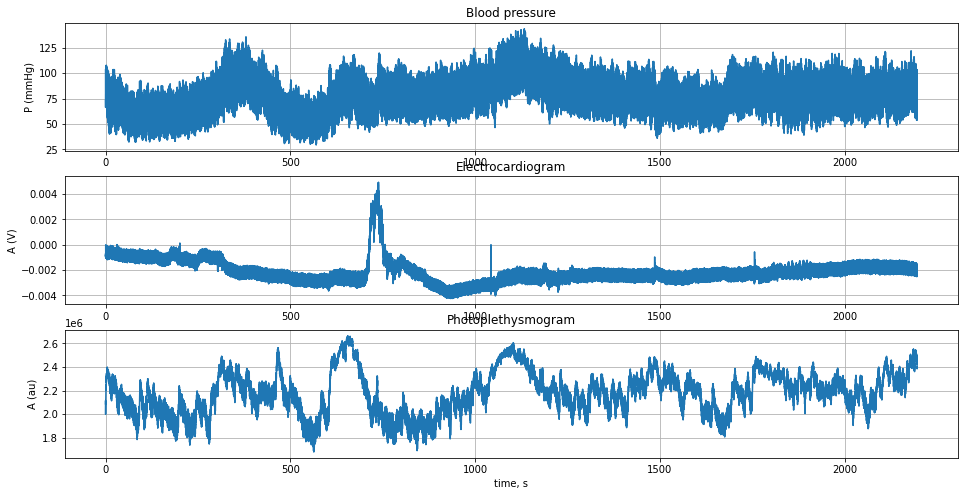

In [312]:
plt.figure()
plt.subplot(311)
time_bp = range(0, len(bp)) /f_bp
plt.plot(time_bp, bp)
plt.title('Blood pressure')
plt.ylabel('P (mmHg)')
plt.grid()

plt.subplot(312)
time_ecg = range(0, len(ecg)) /f_ecg
plt.plot(time_ecg, ecg)
plt.title('Electrocardiogram')
plt.ylabel('A (V)')
plt.grid()

plt.subplot(313)
time_ppg = range(0, len(ppg)) /f_ppg
plt.plot(time_ppg, ppg)
plt.title('Photoplethysmogram')
plt.ylabel('A (au)')
plt.xlabel('time, s')
plt.grid()
plt.show()

## Resample signals to same frequency

In [313]:
Fs = np.array([500])

bp_fs = signal.resample(bp, len(bp)*5) # 5 = 500 /100 TODO: fix


ecg_fs = signal.decimate(ecg, 4) #TODO: fix
timeEcg_fs = range(0, len(ecg_fs)) / Fs

ppg_fs = signal.decimate(ppg, 2) #TODO: fix
timePpg_fs = range(0, len(ppg_fs)) /Fs

## Create low-pass and high-pass filters

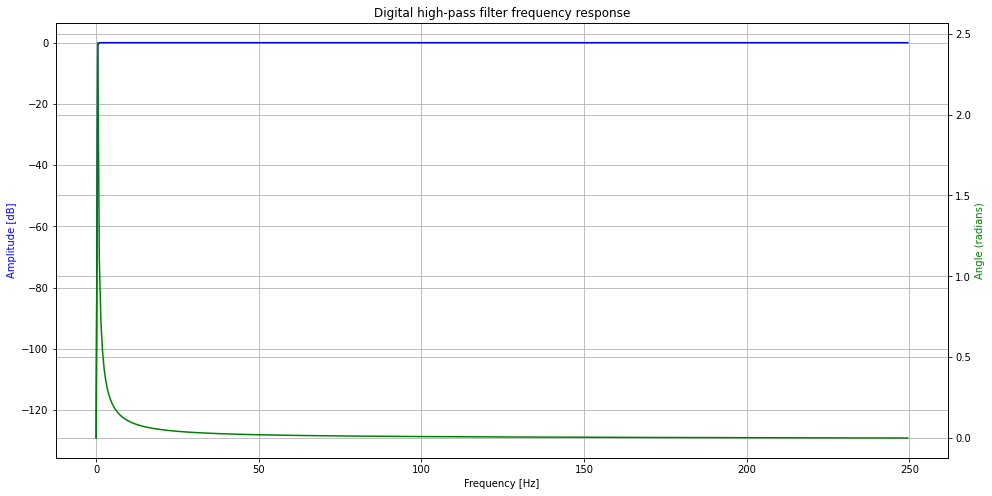

In [314]:
# Recommended filters values
f_co_hp = 0.5
f_co_lp = 17

b_highPass, a_highPass = signal.butter(4, (f_co_hp-0.1)/(Fs/2), btype = 'highpass')

w_1, h_1 = signal.freqz(b_highPass, a_highPass, fs=Fs)
fig, ax1 = plt.subplots()

ax1.set_title('Digital high-pass filter frequency response')
ax1.plot(w_1, 20 * np.log10(abs(h_1)), 'b')
ax1.set_ylabel('Amplitude [dB]', color='b')
ax1.set_xlabel('Frequency [Hz]')
ax1.grid(True)
ax2 = ax1.twinx()

angles = np.unwrap(np.angle(h_1))
ax2.plot(w_1, angles, 'g')
ax2.set_ylabel('Angle (radians)', color='g')
ax2.grid(True)
ax2.axis('tight')
plt.show()

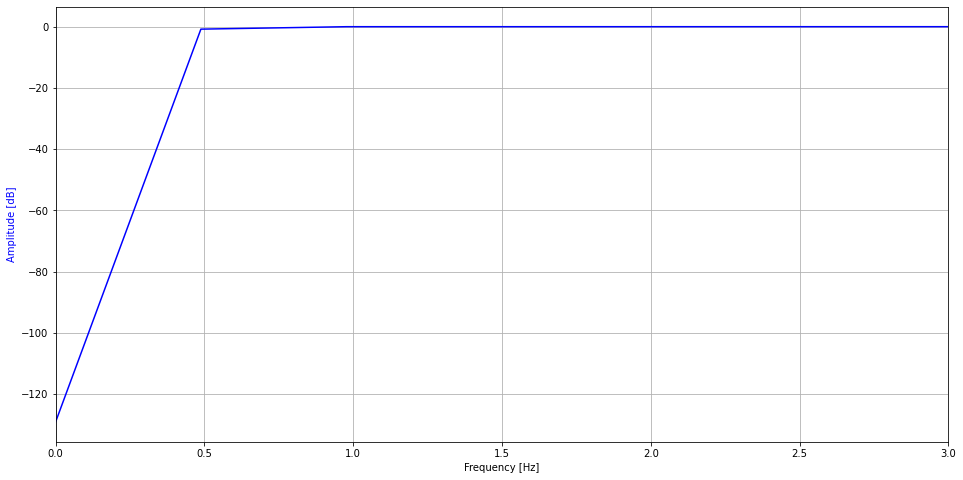

In [315]:
# Zoom in
plt.plot(w_1, 20 * np.log10(abs(h_1)), 'b')
plt.ylabel('Amplitude [dB]', color='b')
plt.xlabel('Frequency [Hz]')
plt.xlim(0, 3.0)
plt.grid()
plt.show()

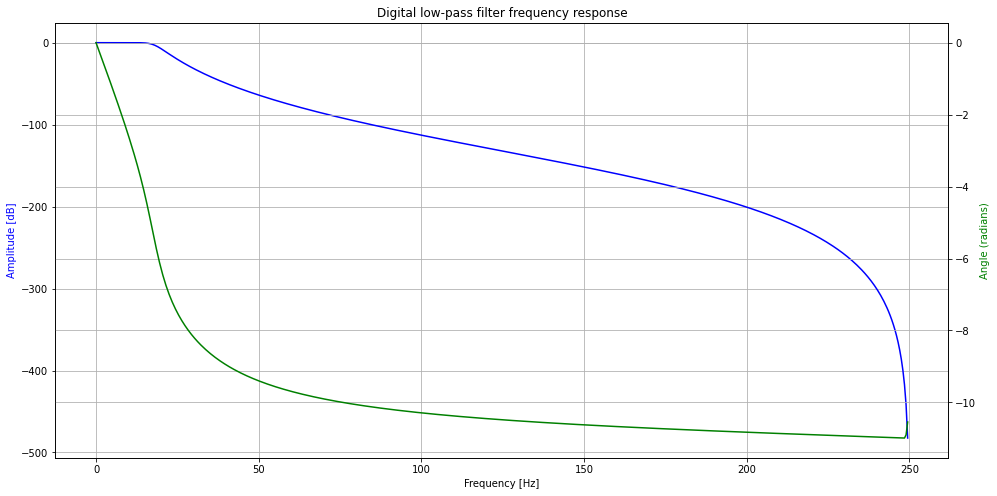

In [316]:
b_lowPass, a_lowPass = signal.butter(7, (f_co_lp+1)/(Fs/2), btype = 'lowpass')

w_2, h_2 = signal.freqz(b_lowPass, a_lowPass, fs=Fs)
fig, ax1 = plt.subplots()

ax1.set_title('Digital low-pass filter frequency response')
ax1.plot(w_2, 20 * np.log10(abs(h_2)), 'b')
ax1.set_ylabel('Amplitude [dB]', color='b')
ax1.set_xlabel('Frequency [Hz]')
ax1.grid(True)
ax2 = ax1.twinx()

angles = np.unwrap(np.angle(h_2))
ax2.plot(w_2, angles, 'g')
ax2.set_ylabel('Angle (radians)', color='g')

ax2.axis('tight')
ax2.grid(True)
plt.show()

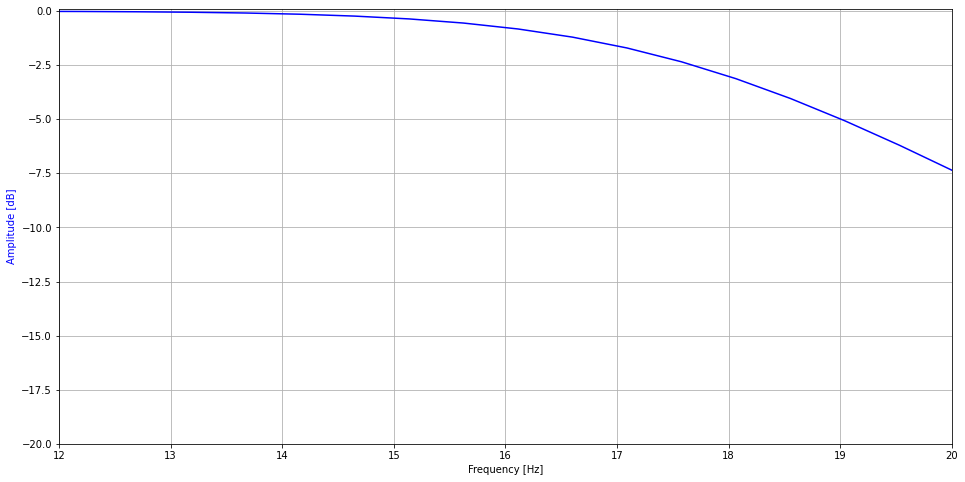

In [317]:
# Zoom in
plt.plot(w_2, 20 * np.log10(abs(h_2)), 'b')
plt.ylabel('Amplitude [dB]', color='b')
plt.xlabel('Frequency [Hz]')
plt.xlim(12, 20.0)
plt.ylim(-20, 0.1)
plt.grid()
plt.show()

## Apply filters

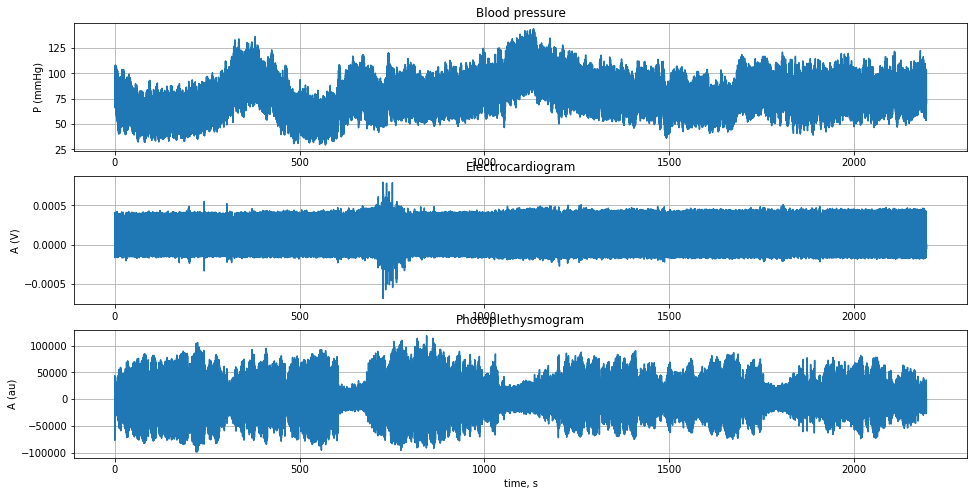

In [318]:
ecg_fs = signal.filtfilt(b_highPass, a_highPass, ecg_fs)
ppg_fs = signal.filtfilt(b_highPass, a_highPass, ppg_fs)

ecg_fs = signal.filtfilt(b_lowPass, a_lowPass, ecg_fs)
ppg_fs = signal.filtfilt(b_lowPass, a_lowPass, ppg_fs)

# Output
plt.figure()
plt.subplot(311)
time_bp_fs = range(0, len(bp_fs)) / Fs
plt.plot(time_bp_fs, bp_fs)
plt.title('Blood pressure')
plt.ylabel('P (mmHg)')
plt.grid()

plt.subplot(312)
time_ecg_fs = range(0, len(ecg_fs)) / Fs
plt.plot(time_ecg_fs, ecg_fs)
plt.title('Electrocardiogram')
plt.ylabel('A (V)')
plt.grid()

plt.subplot(313)
time_ppg_fs = range(0, len(ppg_fs)) / Fs
plt.plot(time_ppg_fs, ppg_fs)
plt.title('Photoplethysmogram')
plt.ylabel('A (au)')
plt.xlabel('time, s')
plt.grid()

plt.show()

## Zoom in

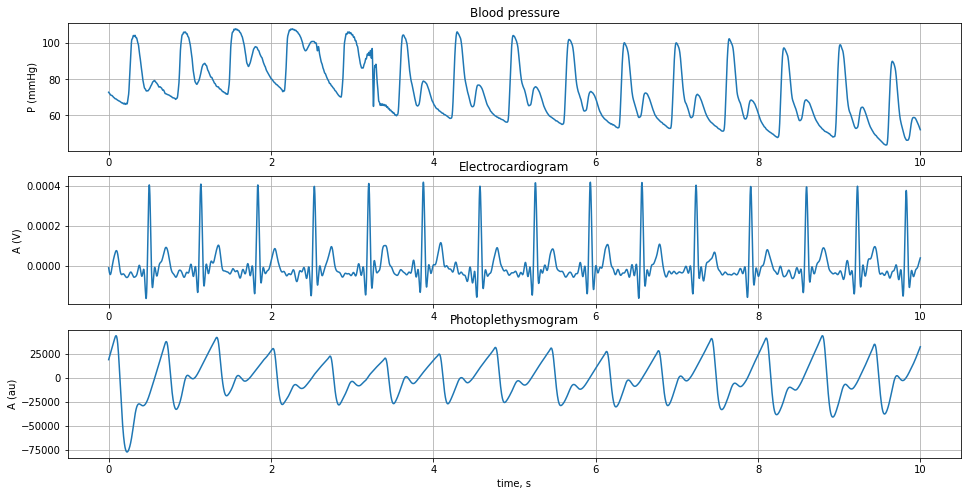

In [319]:
plt.figure()
plt.subplot(311)
time_bp_fs = range(0, len(bp_fs)) / Fs
plt.plot(time_bp_fs[:5000], bp_fs[:5000])
plt.title('Blood pressure')
plt.ylabel('P (mmHg)')
plt.grid()

plt.subplot(312)
time_ecg_fs = range(0, len(ecg_fs)) / Fs
plt.plot(time_ecg_fs[:5000], ecg_fs[:5000])
plt.title('Electrocardiogram')
plt.ylabel('A (V)')
plt.grid()

plt.subplot(313)
time_ppg_fs = range(0, len(ppg_fs)) / Fs
plt.plot(time_ppg_fs[:5000], ppg_fs[:5000])
plt.title('Photoplethysmogram')
plt.ylabel('A (au)')
plt.xlabel('time, s')
plt.grid()

plt.show()

## Extract the features from filtered and resampled signals

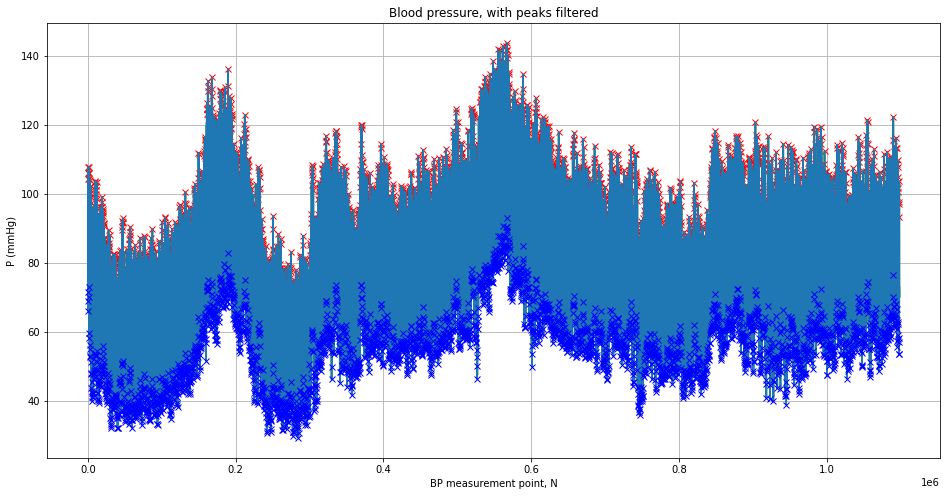

In [320]:
plt.figure()
locSBP_f, _ = find_peaks(bp_fs, distance=50*5)
plt.plot(bp_fs, "g")
plt.plot(locSBP_f, bp_fs[locSBP_f], "rx")

locDBP_f, _ = find_peaks(-bp_fs, distance=50*5)
plt.plot(bp_fs)
plt.plot(locDBP_f, bp_fs[locDBP_f], "bx")

plt.title('Blood pressure, with peaks filtered')
plt.ylabel('P (mmHg)')
plt.xlabel('BP measurement point, N')
plt.grid()

plt.show()

3235
3232


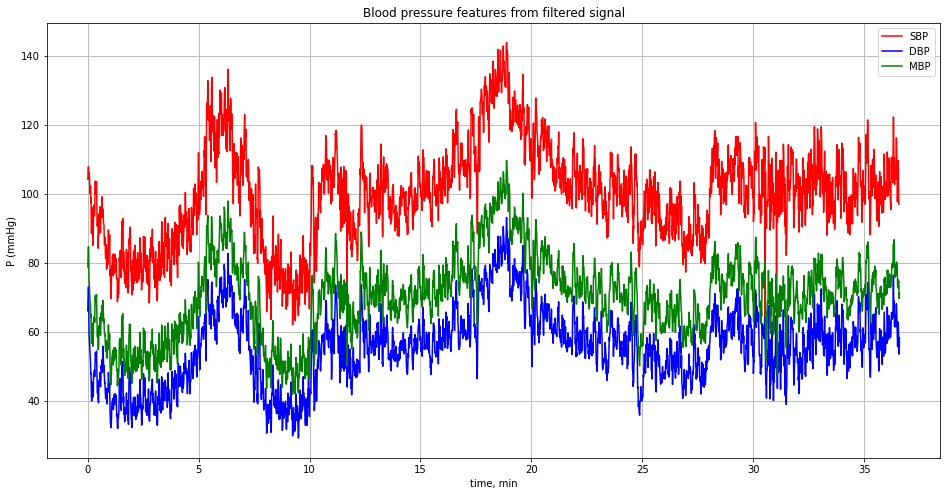

In [321]:
print(len(locSBP_f))
print(len(locDBP_f))

sigLen_fs = np.minimum(len(locSBP_f), len(locDBP_f)) #TODO: we really are just dropping data?

tempSBP_f = bp_fs[locSBP_f]
SBP_f = tempSBP_f[:sigLen_fs]
tempDBP_f= bp_fs[locDBP_f][:sigLen_fs]
DBP_f= tempDBP_f[:sigLen_fs]
MBP_f = (2*DBP_f + SBP_f) / 3


plt.figure()
t_SBP_f=locSBP_f[:sigLen_fs] / Fs;
plt.plot(t_SBP_f/60, SBP_f,'r', label='SBP')
# xlabel('beat No')

t_DBP_f=locDBP_f[:sigLen_fs] / Fs;
plt.plot(t_DBP_f/60, DBP_f,'b', label='DBP')

t_MBP_f = range(0, sigLen_fs) #TODO: check this
plt.plot(t_DBP_f/60, MBP_f,'g', label='MBP')
plt.legend()
plt.title('Blood pressure features from filtered signal')
plt.ylabel('P (mmHg)')
plt.xlabel('time, min')
plt.grid()

plt.show()

## Try to create regresssion model from raw data instead of features 

In [322]:
# Make regression with ANN

# output Y
print(f"Output is BP, which is array of {len(ppg_fs)}, some array values:")
print(bp_fs)

# inputs X
print(f"Input is ECG (length = {len(ecg_fs)}) and PPG (length = {len(ppg_fs)})")
print("ECG:")
print(ecg_fs)
print("PPG:")
print(ppg_fs)

# Here is declared train/test spilt
arrSize   = 750000
arrSizeVal= 250000

dataset = np.array([ecg_fs[:arrSize], ppg_fs[:arrSize]]).T
print("Dataset:")
print(dataset)
print(len(dataset))

X = dataset
Y = bp_fs[:arrSize]
print(X.shape)

dataset_val = np.array([ecg_fs[-arrSizeVal:], ppg_fs[-arrSizeVal:]]).T

X_val = dataset_val
Y_val = bp_fs[-arrSizeVal:]

Output is BP, which is array of 1097930, some array values:
[72.81       72.67413046 72.52293695 ... 72.92905059 72.95538239
 72.910429  ]
Input is ECG (length = 1097930) and PPG (length = 1097930)
ECG:
[-1.07289543e-05 -1.60540052e-05 -2.12755547e-05 ... -4.76290923e-05
 -4.70287875e-05 -4.64612582e-05]
PPG:
[18976.28484591 19547.89106935 20119.24960888 ...  -811.2869917
  -742.06584678  -677.36261115]
Dataset:
[[-1.07289543e-05  1.89762848e+04]
 [-1.60540052e-05  1.95478911e+04]
 [-2.12755547e-05  2.01192496e+04]
 ...
 [-3.35179632e-05 -1.64640794e+04]
 [-2.81592988e-05 -1.64985632e+04]
 [-2.23471755e-05 -1.65213335e+04]]
750000
(750000, 2)


In [324]:
print(X)
print(Y)

[[-1.07289543e-05  1.89762848e+04]
 [-1.60540052e-05  1.95478911e+04]
 [-2.12755547e-05  2.01192496e+04]
 ...
 [-3.35179632e-05 -1.64640794e+04]
 [-2.81592988e-05 -1.64985632e+04]
 [-2.23471755e-05 -1.65213335e+04]]
[72.81       72.67413046 72.52293695 ... 51.25199882 51.2344556
 51.21900811]


In [329]:
from keras.layers import Input, TimeDistributed, LSTM
from keras.models import Model

print(X)
print(X.shape)
x_s = X.reshape((750, 1000, 2))

print("X after spillting")
print(x_s)
print(x_s.shape)

print("Y - outputs")
print(Y.shape)
y_s = Y.reshape((750, 1000))
print(y_s.shape)

[[-1.07289543e-05  1.89762848e+04]
 [-1.60540052e-05  1.95478911e+04]
 [-2.12755547e-05  2.01192496e+04]
 ...
 [-3.35179632e-05 -1.64640794e+04]
 [-2.81592988e-05 -1.64985632e+04]
 [-2.23471755e-05 -1.65213335e+04]]
(750000, 2)
(750000, 2)
X after spillting
[[[-1.07289543e-05  1.89762848e+04]
  [-1.60540052e-05  1.95478911e+04]
  [-2.12755547e-05  2.01192496e+04]
  ...
  [ 1.14362531e-05  2.71669020e+04]
  [ 1.50005957e-05  2.73918440e+04]
  [ 1.85382050e-05  2.76250040e+04]]

 [[ 2.20296339e-05  2.78668766e+04]
  [ 2.54638942e-05  2.81173358e+04]
  [ 2.88380875e-05  2.83755094e+04]
  ...
  [-1.99407902e-06  1.76739848e+04]
  [ 4.33208484e-07  1.78794955e+04]
  [ 2.34487234e-06  1.80861382e+04]]

 [[ 3.74675483e-06  1.82933827e+04]
  [ 4.67026514e-06  1.85005794e+04]
  [ 5.16890626e-06  1.87069798e+04]
  ...
  [-1.64218456e-05  9.23542947e+03]
  [-9.31106922e-06  9.50872937e+03]
  [-4.17573920e-06  9.78080510e+03]]

 ...

 [[-2.79937477e-05 -4.27478848e+04]
  [-2.86843265e-05 -4.250392

In [330]:
print(X_val.shape)
print(Y_val.shape)

x_val_s = X_val.reshape((250, 1000, 2))
y_val_s = Y_val.reshape((250, 1000))
print(x_val_s.shape)
print(y_val_s.shape)
# print(y_val_s[0])

(250000, 2)
(250000,)
(250, 1000, 2)
(250, 1000)


## BP prediction from raw ECG and PPG

The problem with linear regression model is that as an inputs it need medical knowledge to get input features.
The problem with linear regression models is that as inputs it takes medical features which are only obtained with deeper knowledge in that field. Another approach is to use deeper other newer machine learning methods to solve this problem. Here is our attempt to create an initial model using recurrent neural networks with. First tests by using LSTM models were unsuccessful because instead of predicting BP it drew a straight line. To overcome this problem [TimeDistributed](https://keras.io/api/layers/recurrent_layers/time_distributed/) layer and custom neural network was used.

The input for this network was an array of 1000 ECG and PPG values. For training the first 750 thousands data points were used while the latter 250 thousands data points were used for testing.


In [395]:
from keras.layers import Flatten, Dropout

model_in = Sequential([
    Dense(64, activation=tf.keras.layers.LeakyReLU(alpha=0.1)),
    Dense(128, activation=tf.keras.layers.LeakyReLU(alpha=0.1)),
    Dense(256, activation=tf.keras.layers.LeakyReLU(alpha=0.1)),
    Dropout(0.2),
    Dense(128, activation=tf.keras.layers.LeakyReLU(alpha=0.1)),
    Dense(128, activation=tf.keras.layers.LeakyReLU(alpha=0.1)),
    Dropout(0.2),
    Dense(256, activation=tf.keras.layers.LeakyReLU(alpha=0.1)),
    Dense(256, activation=tf.keras.layers.LeakyReLU(alpha=0.1)),
    Dropout(0.2),
    Dense(128, activation=tf.keras.layers.LeakyReLU(alpha=0.1)),
    Dense(128, activation=tf.keras.layers.LeakyReLU(alpha=0.1)),
    Dropout(0.2),
    Dense(64, activation=tf.keras.layers.LeakyReLU(alpha=0.1)),
    Dropout(0.2),
    Dense(64, activation=tf.keras.layers.LeakyReLU(alpha=0.1)),
    Dropout(0.2),
    Dense(1) # last layer must be 1
])

model_f = Sequential()
model_f.add(TimeDistributed(model_in, input_shape=(1000, 2)))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
model_f.compile(optimizer=optimizer, loss='mse', metrics=tf.keras.metrics.RootMeanSquaredError())

model_in.summary()
model_f.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_54 (Dense)             (None, 64)                192       
_________________________________________________________________
dense_55 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_56 (Dense)             (None, 256)               33024     
_________________________________________________________________
dropout_24 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_57 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_58 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_25 (Dropout)         (None, 128)             

In [396]:
callback_f = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.1,
    patience=35,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)
hist = model_f.fit(x_s, y_s, epochs=150, batch_size=16, validation_data=(x_val_s, y_val_s), callbacks=[callback_f], verbose=0)

Restoring model weights from the end of the best epoch.
Epoch 00095: early stopping


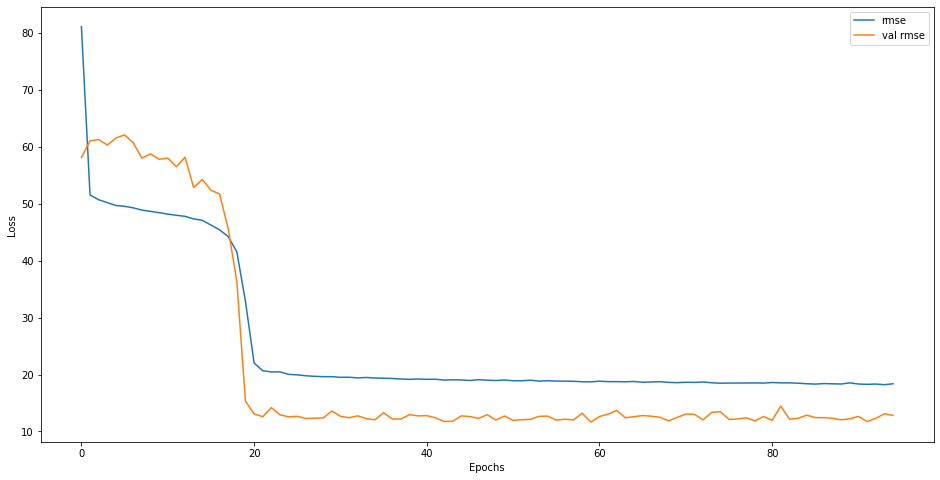

In [397]:
plt.plot(hist.history['root_mean_squared_error'], label = 'rmse')
plt.plot(hist.history['val_root_mean_squared_error'], label='val rmse')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

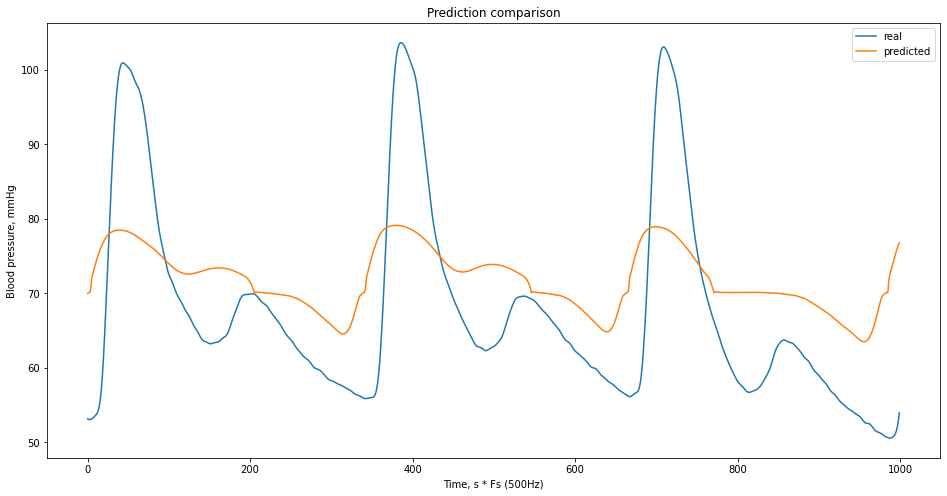

In [398]:
predictions = model_f.predict(x_val_s)
plt.plot(y_val_s[100], label='real')
plt.plot(predictions[100], label='predicted')
plt.ylabel('Blood pressure, mmHg')
plt.xlabel('Time, s * Fs (500Hz)')
plt.title('Prediction comparison')
plt.legend()

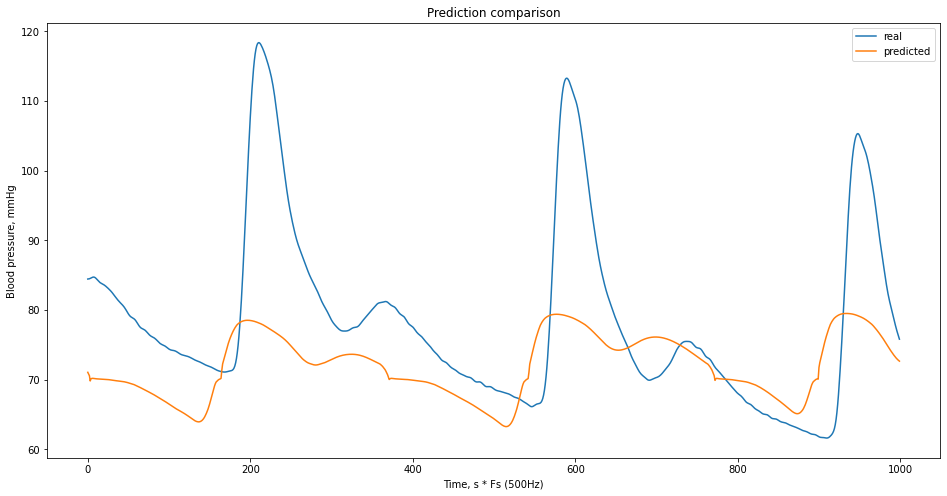

In [400]:
plt.plot(y_val_s[0], label='real')
plt.plot(predictions[0], label='predicted')
plt.ylabel('Blood pressure, mmHg')
plt.xlabel('Time, s * Fs (500Hz)')
plt.title('Prediction comparison')
plt.legend()

It is clear that the model can predict blood pressure with +-10mmHg error. Let’s try to train it on an additional dataset (Painless011.mat) to get better results. The same model were used because dataset should be pretty similar use using [transfer learning](http://https://en.wikipedia.org/wiki/Transfer_learning) should be beneficial 

In [401]:
# if workeing if *_11 dataset we save arrays here
# dataTest = np.loadtxt('/kaggle/input/painlesparams/x_s_01.dat')
# with open('dataOut_11.npy', 'wb') as f:
#     np.save(f, x_s)
#     np.save(f, y_s)
#     np.save(f, x_val_s)
#     np.save(f, y_val_s)
with open('dataOut_11.npy', 'rb') as f:
    x_s11 = np.load(f)
    y_s11 = np.load(f)
    x_val_s11 = np.load(f)
    y_val_s11 = np.load(f)

In [402]:
x_train_all = np.concatenate((x_s, x_s11))
print(x_s.shape)
print(x_s11.shape)
print(x_train_all.shape)
y_train_all = np.concatenate((y_s, y_s11))

x_val_all = np.concatenate((x_val_s, x_val_s11))
y_val_all = np.concatenate((y_val_s, y_val_s11))

(750, 1000, 2)
(750, 1000, 2)
(1500, 1000, 2)


Now we have twice as much data, why not train our model again to see if the results got better.

In [404]:
hist = model_f.fit(x_train_all, y_train_all, epochs=150, batch_size=32, validation_data=(x_val_all, y_val_all), callbacks=[callback_f], verbose=0)

Restoring model weights from the end of the best epoch.
Epoch 00039: early stopping


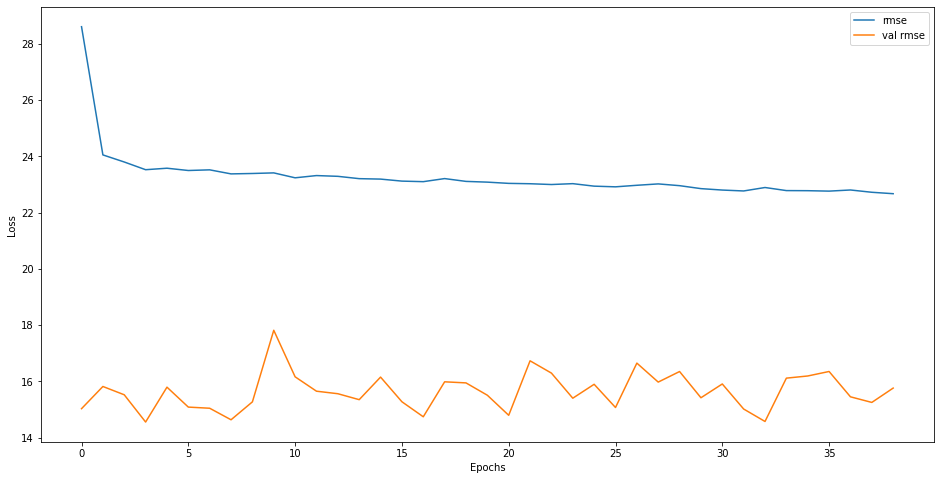

In [405]:
plt.plot(hist.history['root_mean_squared_error'], label = 'rmse')
plt.plot(hist.history['val_root_mean_squared_error'], label='val rmse')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

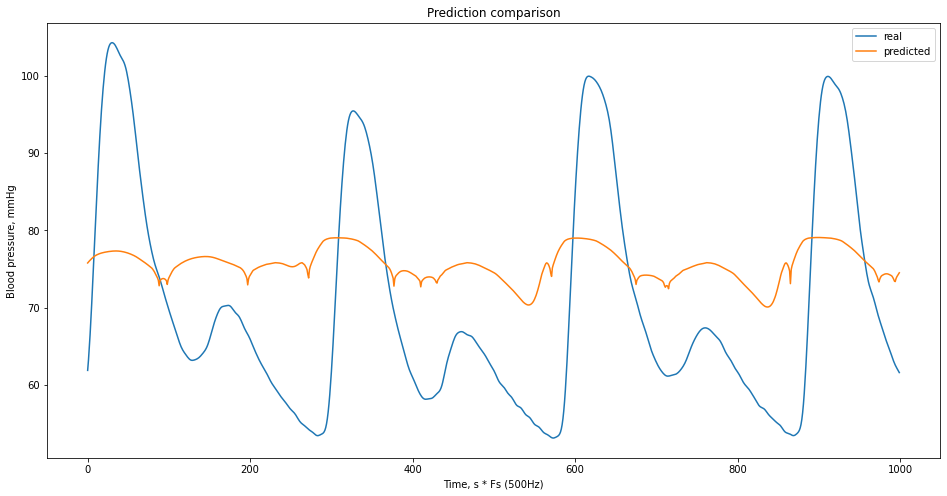

In [406]:
predictions = model_f.predict(x_val_s)
plt.plot(y_val_s[60], label='real')
plt.plot(predictions[60], label='predicted')
plt.ylabel('Blood pressure, mmHg')
plt.xlabel('Time, s * Fs (500Hz)')
plt.title('Prediction comparison')
plt.legend()

We can see that **additional data did not improve models’ results** which is unusual in machine learning problems. From this experiment concussion can be drawn that Painless021.mat dataset consist of better/less noisier measurements.

## With Normalized

In [ ]:
# same model with normalized BP
tf.keras.backend.clear_session()
model_in = Sequential([
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1) # last layer must be 1
])

# model_in.summary()
model_f = Sequential()
model_f.add(TimeDistributed(model_in, input_shape=(1000, 2)))

# model_f.compile(optimizer='adam', loss='mse')
# model_f.compile(optimizer='adam', loss='mse')
model_f.compile(optimizer='adam', loss='mse', metrics=tf.keras.metrics.RootMeanSquaredError())


callback_f = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=15)
model_f.fit(x_s, norm_y_s, epochs=150, batch_size=48, validation_data=(x_val_s, norm_y_val_s), callbacks=[callback_f])


In [ ]:
predictions_n = model_f.predict(x_val_s)
# print(predictions)
plt.plot(norm_y_val_s[100])
plt.plot(predictions_n[100])

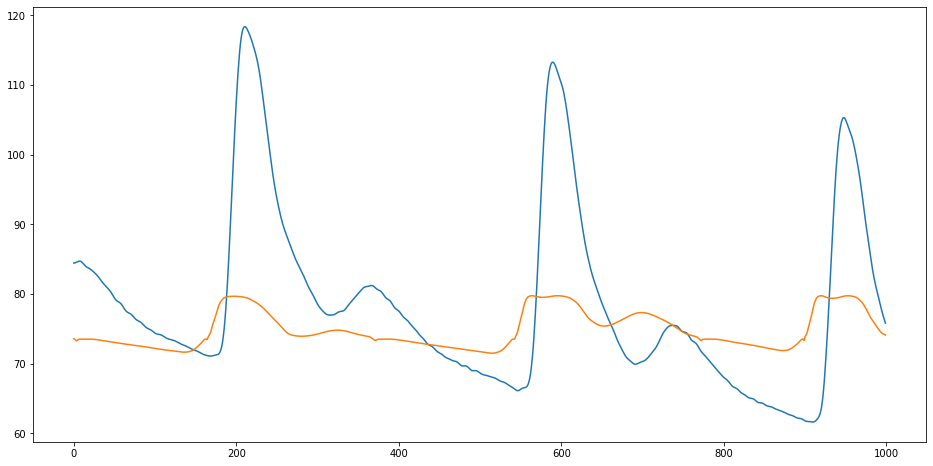

In [358]:
predictions_all = model_f.predict(x_val_all)
plt.plot(y_val_all[0])
plt.plot(predictions_all[0])

## Let's try predict SBP from parateres (calculated with MATLAB) with ANN/Regression/LSTM 

In [407]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/painlesparams/y_val_s_01.dat
/kaggle/input/painlesparams/y_val_s_02.dat
/kaggle/input/painlesparams/x_val_s_02.dat
/kaggle/input/painlesparams/x_s_01.dat
/kaggle/input/painlesparams/x_val_s_01.dat
/kaggle/input/painlesparams/y_s_02.dat
/kaggle/input/painlesparams/x_s_02.dat
/kaggle/input/painlesparams/y_s_01.dat
/kaggle/input/painlesparams/matlabSignals.mat
/kaggle/input/d/zygimantasmarma/painlessdb/Painless011.mat
/kaggle/input/d/zygimantasmarma/painlessdb/Painless021.mat


<class 'numpy.ndarray'>
[106.08896777 107.77006064 107.79007365 ...  97.12313914  93.48359379
  97.72352945]
(3240,)


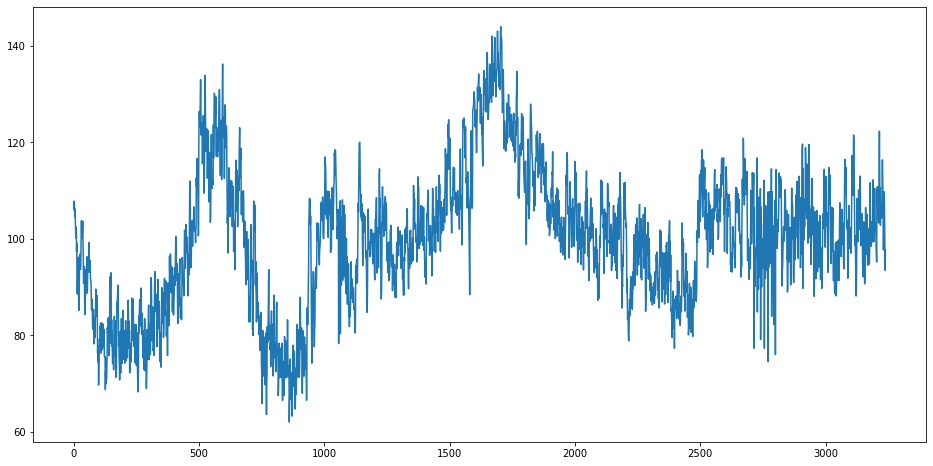

In [408]:
#REDO: save into one .mat file
matDataSBP = scipy.io.loadmat('/kaggle/input/painlesparams/matlabSignals.mat').get('SBP')[0] # Specific data path for kaggle
matDataPIR = scipy.io.loadmat('/kaggle/input/painlesparams/matlabSignals.mat').get('PIR')[0] # Specific data path for kaggle
matDataPAT = scipy.io.loadmat('/kaggle/input/painlesparams/matlabSignals.mat').get('PAT')[0] # Specific data path for kaggle
matDataHR  = scipy.io.loadmat('/kaggle/input/painlesparams/matlabSignals.mat').get('HR')[0]  # Specific data path for kaggle


print(type(matDataSBP))
print(matDataSBP)
print(matDataSBP.shape)
plt.plot(matDataSBP)


In [ ]:
plt.plot(matDataSBP[:50])

In [409]:
# from tf.keras.layers.normalization import BatchNormalization
def param_model():
    model = Sequential()
    if 1:
        model.add(Dense(32, input_shape=(3,), kernel_initializer='normal', activation='relu'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(Dense(64, kernel_initializer='normal', activation='relu'))
#         model.add(Dropout(0.1))
        model.add(Dense(32, kernel_initializer='normal', activation='relu'))
#         model.add(Dropout(0.2)) 
        model.add(Dense(1, kernel_initializer='normal'))
    else:
        model.add(Dense(32, activation=tf.keras.layers.LeakyReLU(alpha=0.1)))
        model.add(Dense(64, activation=tf.keras.layers.LeakyReLU(alpha=0.1)))
        model.add(Dense(128, activation=tf.keras.layers.LeakyReLU(alpha=0.1)))
        model.add(Dropout(0.2))
        model.add(Dense(128, activation=tf.keras.layers.LeakyReLU(alpha=0.1)))
        model.add(Dropout(0.2))
        model.add(Dense(256, activation=tf.keras.layers.LeakyReLU(alpha=0.1)))
        model.add(Dropout(0.2))
        model.add(Dense(128, activation=tf.keras.layers.LeakyReLU(alpha=0.1)))
        model.add(Dropout(0.2))
        model.add(Dense(64, activation=tf.keras.layers.LeakyReLU(alpha=0.1)))
        model.add(Dropout(0.2))
        model.add(Dense(32, activation=tf.keras.layers.LeakyReLU(alpha=0.1)))
        model.add(Dropout(0.2))
        model.add(Dense(1)) # last layer must be 1
    return model

print(matDataPIR.size)

x_param = np.array([matDataPIR, matDataPAT, matDataHR])
x_param = np.transpose(x_param)
y_param = np.array(matDataSBP)
y_param = y_param.reshape(3240,1)
print(x_param.shape)
print(y_param.shape)

3240
(3240, 3)
(3240, 1)


In [410]:
trainDataCount = 1572
testDataCount = 1108


x_train = x_param[0:trainDataCount]
y_train = y_param[0:trainDataCount]

x_val = x_param[trainDataCount:trainDataCount+testDataCount]
y_val = y_param[trainDataCount:trainDataCount+testDataCount]

# model_in.summary()
tf.keras.backend.clear_session()
model_p = param_model()
# model_p.compile(optimizer='adam', loss='mse', metrics=tf.keras.metrics.RootMeanSquaredError())
model_p.compile(loss='Huber',
                optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
                metrics=tf.keras.metrics.RootMeanSquaredError()
                 )

callback_f = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.1,
    patience=35,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)
model_p.fit(x_train, y_train, epochs=120, batch_size=16, validation_data=(x_val, y_val), callbacks=[callback_f])

Epoch 1/120
99/99 [==============================] - 1s 8ms/step - loss: 85.0900 - root_mean_squared_error: 88.0141 - val_loss: 306.7066 - val_root_mean_squared_error: 313.7645
Epoch 2/120
99/99 [==============================] - 0s 4ms/step - loss: 39.5165 - root_mean_squared_error: 47.4107 - val_loss: 42.0104 - val_root_mean_squared_error: 50.1561
Epoch 3/120
99/99 [==============================] - 0s 4ms/step - loss: 18.2625 - root_mean_squared_error: 24.7720 - val_loss: 213.4306 - val_root_mean_squared_error: 214.7012
Epoch 4/120
99/99 [==============================] - 0s 4ms/step - loss: 11.2494 - root_mean_squared_error: 14.2909 - val_loss: 102.7902 - val_root_mean_squared_error: 105.2888
Epoch 5/120
99/99 [==============================] - 0s 4ms/step - loss: 11.2163 - root_mean_squared_error: 14.2101 - val_loss: 53.7788 - val_root_mean_squared_error: 57.4160
Epoch 6/120
99/99 [==============================] - 0s 4ms/step - loss: 10.9583 - root_mean_squared_error: 13.9645 - v

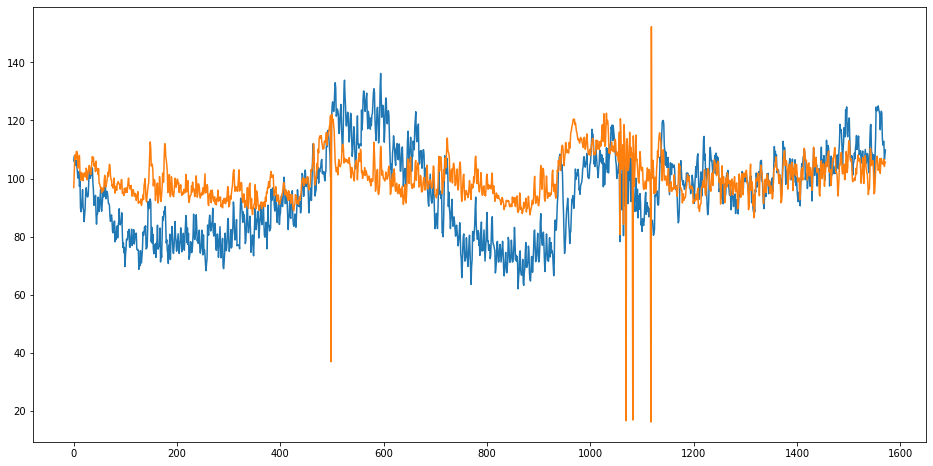

In [411]:
# show what we trained
pred_t = model_p.predict(x_train)
plt.plot(y_train)
plt.plot(pred_t)

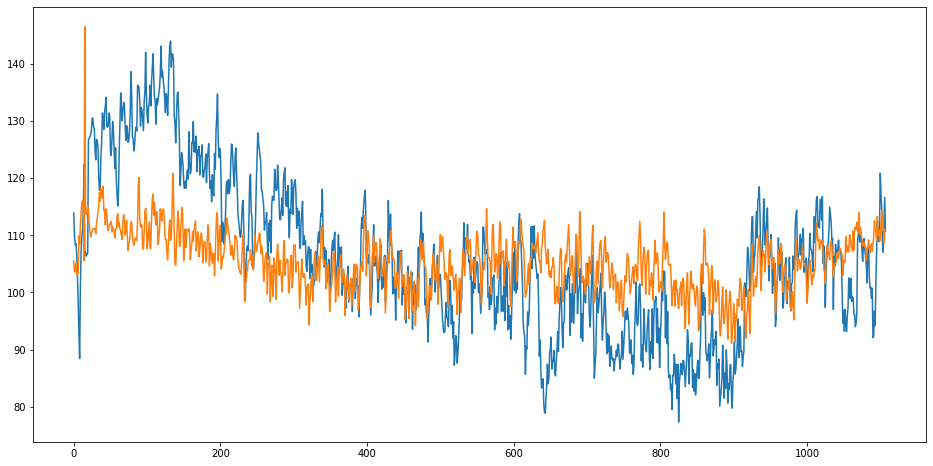

In [412]:
predictions_n = model_p.predict(x_val)
# print(predictions)
plt.plot(y_val)
plt.plot(predictions_n)